# Notes 12/28/17
* WMO format for exchanging observations
* Old, before internet
* All satellite data arrives in BUFR
* Different format for each obs
* Table driven
* High level scripts from Clara Draper
    * JEDI_conv_bufr2nc_2D.py
    * JEDI_amsu_bufr2nc.v8.py
* iMac is little-endian and test data may be big-endian
    * This happened with GSI test case
    * Can workaround this using: gfortran -fconvert=big-endian
        * This tells compiler that unformatted files are big-endian

## py-ncepbufr
* GitHub: jswhit/py-ncepbufr
* f2py wrapper
* Old Fortran code base (F77)
    * object files get collected into libbufr.a archive file
* If make change, rebuild by:
    * rm -rf src/libbufr.a build ~/.local/*
    * python setup.py install --user --record files.txt > setup.log 2>&1 &
    * Unfortunately, this system does not track dependencies
* bufr instance is constructed in ncepbufr/__init__.py
    * import _bufrlib #this is the fortran library libbufr.a
    * _bufrlib.fortran_open() # this opens the BUFR file, routine fortran_open in fortran_open.f
    * _bufrlib.openbf() # this reads in the table information, routine openbf in openbf.f
    * Ie, each method of the _bufrlib instance is a routine with the same name whose source code is in a file with the same name
    * The methods defined in __init__.py are the ones called by the top level python script

### setup.py
* First section will build the libbufr.a file if missing
    * Does not rebuild if a source file changes
        * source is .f (F77) and .c
    * cd's to src directory and runs makebufrlib.sh
* Second section creates three python extensions
    * _bufrlib
        * f2py wrapper of the libbufr.a file
        * Uses src/_bufrlib.pyf
            * Created by f2py run outside of this system, and optionally modified by developer
    * _read_convobs
        * f2py wrapper of src_diag/readconvobs.f90
    * _read_satobs
        * f2py wrappers of src_diag/readsatobs.f90, src_diag/read_diag.f90
* Third section creates the ncepbufr python package
    * builds a .so file for each of the three extensions
    * builds two packages: ncepbufr and read_diag

### Debug
* Successfully built and installed ncepbufr python packages
    * Inside and outside container
    * Need to install anaconda in both before setup.py would work
        * This is way to get Distutils python package which is what setup.py uses
* Tried JEDI_*.py scripts and code quits during the openbf call
    * Message:
        At line 63 of ifxy.f
        Fortran runtime error: Bad value during integer read
        
        FUNCTION IFXY(ADSC)
        
        CHARACTER*6 ADSC
        
        READ(ADSC, '(I1,I2,I3)') IF,IX,IY
        
        ADSC holds digits representing the code to look up in the BUFR table
        
    * Got same error when running test in the ncepbufr repository
        cd test
        python test.py
    * Error persisted with both python 2.7 and python 3.6
        * anaconda is configured to be able to switch between python2.7 and python3.6
            * source activate python27 --> python 2.7
            * source deactivate --> python 3.6
* Added iostat parameter to the READ command and got 5010 for the error code
    * 5010 means bad data (redundant to the initial message)
* Tried several things inside the ifxy routine
    * MYADSC as a local variable, and put MYADSC into the READ statement
        * copy ADSC into MYADSC
        * set MYADSC to '063000'
    * Variations on the READ statement
        * READ(ADSC(1:6), '(I1,I2,I3)') IF,IX,IY
        * READ(ADSC(1:1), '(I1)') IF, ditto for IX and IY
    * Print out value of ADSC
    * ADSC had the expected value in it, but error persisted
* Tried writing a separate test program
    * ADSC = '063000' in main
    * call function name IFXY
        * READ(ADSC, '(I1,I2,I3)') IF,IX,IY
    * This worked as expected
* Seems like something is stomping on memory
    * Tried setting stack space to "unlimited" (ulimit -s unlimited), but error persisted


# Notes, 1/2/18

## py-ncepbufr
* Tried -DNORMAL in makebufr.sh, did not work
    * This makes the array sizes considerably smaller
* Tried putting MAXNC back to 300 in bufrlib.h, did not work
* Tried setting IPRT = 1 in openbf.f (to get more diagnostics), but this gets a seg fault in WRDLEN
    * Seg fault is during a WRITE(UNIT=ERRSTR, FMT='(A,I2)') command in wrdlen.f
    * CHARACTER\*128 ERRSTR
    * Interesting that read/write from/to strings is what breaks
* Tried linking Fortran code that links directly to the libbufr.a archive
    * Directly call IFXY() works
    * Directly call FORTRAN_OPEN() and OPENBF() works
    * The problem seems to be in the python <--> Fortran interface
* Tried python27
    * Python interface gets Seg fault
    * Fortran direct calls works
* Tried small f2py test case suggested at website:
    * https://sysbio.ioc.ee/projects/f2py2e/index.html#usage
    * This works

# Notes, 1/4/18
## Meeting with Jeff Whitaker
* Issues with gfortran
    * I'm using gfortran 7
    * Someone else had issue with gfortran 7 and got it to work by using gfortran 6
        * Not a very good solution, but useful for debugging
    * Clara got hers working with g95
* Try older compiler on my iMac
    * gfortran 6 or g95
    * macports
    * direct download of source code or binaries
* Strings are tricky
    * f2py creates a C wrapper around the Fortran code, then the .so file provides the C routines callable from Python
    * Maybe something is getting corrupted in the string ifxy() is trying to read
        * null byte or some non-visible character
        * Dump out hex pattern
        * Not sure about this though, since the issue is with a Fortran string literal passed to ifxy()
* If I fix a bug, send pull request to Jeff on GitHub
    * MAXNC mismatch between .h (C) and .PRM (Fortran) files
    * Fix for read/write failures

## MacPorts
* Installation of MacPorts itself
    * Instructions: https://guide.macports.org/#installing.shell
    * Source install
        curl -O https://distfiles.macports.org/MacPorts/MacPorts-2.4.2.tar.bz2  
        tar xvf MacPorts-2.4.2.tar.bz2  
        cd MacPorts-2.4.2  
        ./configure  
        make  
        sudo make install  
        edit ~/.bash_profile
            export PATH="/opt/local/bin:/opt/local/sbin:$PATH"  
            export MANPATH="/opt/local/share/man:$MANPATH"  
        restart in a new window
        sudo port selfupdate
* Install gfortran 6
    * Command: sudo port install gcc6
        * installs gfortran 6.4.0 in: /opt/local/bin/gfortran-mp-6
    * Command: sudo port install gcc7
        * installs gfortran 7.2.0 in: /opt/local/bin/gfortran-mp-7
* Select a version
    * Command: sudo port select --set gcc mp-gcc6
        * creates symlinks for gcc, g++, gcov, gfortran pointing to corresponding -mp-6 versions
    * Command: sudo port select --set gcc mp-gcc7
        * creates symlinks pointing to -mp-7 versions
    * Command: sudo port select --set gcc none
        * deletes symlinks

## Use gfortran 6 to build py-ncepbufr package
* Edit src/makebufrlib.sh
    Comment out FC and CC settings
* Edit setup.py  
    Add at beginning:  
        os.environ["CC"] = "gcc-mp-6"  
        os.environ["CXX"] = "gcc-mp-6"  
        os.environ["FC"] = "gfortran-mp-6"  
        os.environ["F77"] = "gfortran-mp-6"  
        os.environ["F90"] = "gfortran-mp-6"  
* Run  
        python setup.py install --user --record=files.txt > setup.log 2>&1 &  


# Notes, 1/8/18
* Further debug efforts on the read error
* Created fork from jswhit/py-ncepbufr repository
    * Created branch: read_error
    * This is for debugging the error that occurs in ifxy() during the read statement
    * Created debug directory to do work, so that git doesn't get all cluttered with test files
    * Created debug/src directory
        * ifxy.f: subroutine that does a read on its argurment (string of digits)
        * tryme.f: subroutine that calls ifxy()
        * tryme_main.f: main program that calls ifxy()
        * ifxy.f90: version of ifxy.f in Fortran 90 syntax
        * tryme.f90: version of tryme.f in Fortran 90 syntax
* In the forked repository, on the read_error branch, tried setup.py with consistent C and Fortran compilers
    * gcc7 (gfortran-mp-7, gcc-mp-7) -> fails
    * gcc6 (gfortran-mp-6, gcc-mp-6) -> works
* For experiments:
    * For dynamic libraries and bundles, need to compile with -fPIC (position independent code)
    * .so file is a "bundle" which cannot be linked, but can be read in as a module in Python
        * This is what setup.py, f2py, etc. create
        * gfortran -bundle -undefined dynamic_lookup
    * .a file is a static library which can be linked
        * gfortran -fPIC -c *.f # creates .o file
        * ar *.o
    * .dylib file is a shared library which can be linked
        * gfortran -fPIC -dynamiclib -o libifxy.dylib ifxy.f
* In the debug directory
    * Created link_to_fortran directory for testing code directly linked to a fortran main program
        * build_pgms script will create two binaries: 
            * tryme_static: calls ifxy() through a static library version
            * tryme_dynamic: calls ifxy() through a dynamic library vesion
        * These both work using gcc7
    * Created various modules using f2py
        * build_modules script will build four modules (bundles):
            * mymod_gcc6.cpython-36m-darwin.so: gcc6 compiled, f77 source
            * mymod90_gcc6.cpyton-36m-darwin.so: gcc6 compiled, f90 source
            * mymod_gcc7.cpython-36m-darwin.so: gcc7 compiled, f77 source
            * mymod90_gcc7.cpyton-36m-darwin.so: gcc7 compiled, f90 source
        * The two gcc6 modules work, and the two gcc7 modules fail
        * Tried gcc6, f77 source with the "only: tryme" clause on f2py
            * This creates an interface (fortran -> C -> python) only for the tryme routine
            * This failed too
        * Tried changing optimization level for compilers
            * f2py --opt='-O2' ...: fails for gcc7
            * f2py --opt='-O1' ...: fails for gcc7
            * f2py --opt='-O0' ...: fails for gcc7
            

# Notes, 1/9/18
* Tried building a python module from scratch (without f2py)
    * Put this in debug/hand_made_module
    * Script build_all
* This initially broke for gfortran-mp-7
* Discovered that the issue is the wrong libgfortran file was getting linked in
    * Anaconda installs a libgfortran.dynlib in ~/anaconda3/lib
        * Apparently, this is compatible with gcc6 but not gcc7
        * Explains why read/write were broken
    * distutils places the anaconda3/lib path in the loader step (and not the gcc7 lib path)
* Workaround is to override the link path
    * Works to export LDPATH
        * LDPATH="-bundle -undefined dynamic_lookup -L/opt/local/lib/gcc7"
        * the bundle and undefined options are needed since these go away when the user sets LDPATH
* Real fix is to install gcc (c, c++, fortran compilers) into anaconda and fix the broken link path
    * conda install -c anaconda gcc
    * This works on my iMac
* Made small change to py-ncepbufr makebufr.sh script so that the user could pass in settings for the C and Fortran compilers

# Notes, 1/10/18
* Created pull request for the change in makebufr.sh that allows FC and CC to be set in environment
* Tried building py-ncepbufr in virtual machine
    * Installed gcc in anaconda
    * build worked, but shared library file fails to load
    * Get error: cannot map zero-fill pages
* Search on net says this is due to running out of memory
    * Tried test program (in ~/project/test_alloc) which was able to allocate 4GB!
    * Not a memory issue, but I'm not able to find what else can cause the share library to not load


# Notes, 1/25/18
* Help Xin with converting aircraft obs from BUFR to netCDF
* He isn't quite ready yet to use the netCDF aircraft obs data
* He perfers to use a utility (pb2nc) from the DTC MET group
* Easiest way to get access to pb2nc is to run MET's Docker image
    * Note: 6.1 is the latest version, but it is missing from the website
    
~~~~~~~~~
wget http://www.dtcenter.org/met/users/support/online_tutorial/docker_data/container-met-6.0-tutorial.tar.gz
    
docker load -i container-met-6.0-tutorial.tar.gz
mkdir MET_Tutorial_6.0
cd MET_Tutorial_6.0
export MET_TUTORIAL_DIR=$(pwd)

docker run --rm -it -v ${MET_TUTORIAL_DIR}/MET_Tutorial:/met/met-6.0/MET_Tutorial met-6.0-tutorial /bin/bash
cd /met/met-6.0
~~~~~~~~~

* Once inside the container (following commands above), try a couple conversions
    * Create a workspace: /met/met6.0/projects/pb2nc, and cd there
    * Tutorial example
        * wget https://dtcenter.org/met/users/support/online_tutorial/METv6.1/config/PB2NCConfig_default
        * mv PB2NCConfig_default PB2NCConfig_tutorial
        * Follow edit instructions:  
            https://dtcenter.org/met/users/support/online_tutorial/METv6.1/tutorial.php?name=pb2nc&category=configure
        * pb2nc ../../data/sample_obs/prepbufr/ndas.t00z.prepbufr.tm12.20070401.nr ndas_pb.nc PB2NCConfig_default
    * Xin's file example
        * wget http://www.ftp.ncep.noaa.gov/data/nccf/com/gfs/prod/gfs.2018012506/gfs.t06z.prepbufr.nr
        * cp PB2NCConfig_tutorial PB2NCConfig_aircraft
        * edit PB2NCConfig_aircraft
            * Change the message_type array to [ "AIRCFT", "AIRCAR" ]
            * Change obs_window to -5400, 5400 (3 hour window with time 0 in the center)
        * pb2nc gfs.t06z.prepbufr.nr gfs_pb.nc PB2NCConfig_aircraft
* Handy guide for BUFR  
    https://dtcenter.org/com-GSI/BUFR/docs/users_guide/BUFR_PrepBUFR_User_Guide_v1.pdf  
    
    * Put a copy of above guide on my UCAR Google Drive
    * Page 72 has links to handy tables showing many of the message codes

# Notes, 1/31/18
* The above docker command that runs the containter (docker run ...) sets up a shared directory between host and guest processes
    * -v host_path:guest_path
    * Any files placed by the host process into host_path will show up in the guest process in guest_path, and vice-versa
* Table showing meaning of BUFR mnemonics  
    http://www.emc.ncep.noaa.gov/mmb/data_processing/prepbufr.doc/table_1.htm


# Notes, 2/2/18
## Aircraft obs data
* py-ncepbufr and pb2nc produce different netCDF files
    * sample obs netcdf in UFO repository is different from py-ncepbufr and pb2nc formats
* data are probabaly the same, but data is organized in different manners
* pb2nc
    * All vars are in group "/"
    * Vars
        * hdr_typ(Nhdr): message type
        * hdr_sid(Nhdr): station id
        * hdr_vld(Nhdr): valid time
        * hdr_arr(Nhdr,HdrTypes): station header values
            * HdrTypes size is 3
                * 0: lat: latitude, degrees_north
                * 1: lon: longitude, degrees_east
                * 2: elv: elevation (m) above sea level (msl)
        * obs_qty(Nobs): observation quality flag
        * obs_arr(Nobs,ObsTypes): observation values
            * ObsTypes size is 5
                * 0: hdr_id, index of matching header data
                * 1: gc, grib code for obs type
                * 2: lvl, pressure level (hPa) or accum. interval (sec)
                * 3: hgt, height (m) above sea level (msl)
                * 4: ob, obs value
* py-ncepbufr, JEDI_conv_bufr2nc_2D.py (Clara)
    * Clara said this is model of what should be created for the aircraft obs data
    * All vars are in group "/"
    * Vars
        * idate(Nobs): valid time    
        * msg_type(Nobs): message type
        * SID(Nobs): station id
        * XOB(Nobs): longitude of obs
        * YOB(Nobs): latitude of obs
        * POB1(Nobs): pressure obs value, 1 level only (e.g. sfc)
        * POB2(Nobs,Nlevs): pressure obs value, multiple levels
        * TPC_benv2(Nobs,NbenvLayers): temperature event program code
        * TPC_benv3(Nobs,Nlevs,NbenvLayers): temperature event program code
        * Etc., following the naming of data values in the BUFR table
            * Naming convention
                * Vname1 is for obs taken at a single level
                * Vname2 is for obs taken at multiple levels
                * Vname_benv2 is for buffer event at a single level
                * Vname_benv3 is for buffer evernt at multiple levels
    * The Vname1, Vname2 organization was done to reduce storage space
        * Before, just a single POB var was written into the file
        * Had to make the dimensions (Nobs,Nlevs) to accommodate a few multi-level obs values
        * Single-level obs values wasted space since only one level was filled with actual data
* UCAR/ufo/test/testinput/&ast;&#95;obs.nc files (Xin)  
    * Xin said this is model of what should be created for the aircraft obs data
    * All vars are in group "/"
    * Vars (from satellite example, amsua_n19_obs.nc4)
        * chaninfoidx(Nchans): Description of instrument
        * frequency(Nchans)
        * ...
        * Observation_Class(Nobs): Description of observation (location, time, etc)
        * Latitude(Nobs)
        * Longitude(Nobs)
        * ...
        * Water_Fraction(Nobs): Observation data values
        * Land_Fraction(Nobs)
        * Ice_Fraction(Nobs)
        * ...
* The formats that Clara and Xin gave me are pretty close to the same thing.
    * Use JEDI_conv_bufr2nc_2d.py as starting point
* All of the tools that parse BUFR appear to be based on the same Fortran library
    * libbufr.a
    * These are the routines described in the BUFR manual

## Discussion with Clara, 2/1/18
* History of py-ncepbufr and JEDI_conv_bufr2nc_2D.py
    * Jeff Whitaker created a demo script (prepbufr2nc) along with the Python interface
    * Scott Gregory took the demo and made an example tailored to a specific file spec
    * Clara Draper finished the work that Scott started
        * Two scripts: 
            * JEDI_conv_bufr2nc_2d.py: Conventional obs
            * JEDI_amsua_bufr2nc_v8.py: Satellite (AMSU-A 15 channel microwave radiometer)
    * The format from JEDI_conv_bufr2nc_2d.py resulted from a recent code sprint
        * Mimicking GSI input format (obs diag files) to minimize modification to GSI
        * Want to end up with common format for obs
* Not sure what buffer events are
    * This was a sticking point when Clara was developing the scripts
    * Guessing an event is a past obs that is used for QC of the current obs
    * Look at BUFR manual
        * ufbenv() routine to read an event
        * Related to QC
        * Used to process temperature
        * Memory of previous time data point
        * Store difference
            * This might be the "event"
            * Chain of differences going back from current obs
        * Look out for data that contains events
            * Will need the ufbenv() routine
                * This is a method on the object that is one below a "subset"
* JEDI treats DA as an object, GSI is the first implementation of a DA object
* Separated files for each obs type
    * Yannick concurs with this
    * Motivation for separate files
        * Metadata storage in netCDF is inefficient
            * Eg. location is stored in an array that is same size as obs values
            * The same location value is repeated in all of the entries
    * Separating obs types into different files helps mitigate the redunancy of metadata
    * Eg of different obs types
        * Ship
        * Sonde
        * Balloons
        * Aircraft
* Terminology
    * Conventional
        * Anything except satellite
        * Balloons
        * Ships
        * Sondes
        * Radar
* Started with GSI input format in netCDF and will evolve from there
* Difficult to put different obs types in single script
    * Lots of switches
    * Information types change depending on source
* Look at GSI routine for guidance on aircraft obs file
    * read_prepbufr.f90
    * mimic the format the read_prepbufr() is reading
    * look for "AIRCFT" and "AIRCAR"
* Single-level and Multi-level obs were separated to save storage space
    * Leads to TOB splitting into two netCDF vars: TOB1 (single-level), TOB2 (multi-level)
    * Switching to different file for each obs type will eliminate the need to do the variable splitting
        * The obs type will determine the shape of the obs array
        
## Discussion with Xin, 2/1/18
* Looking at both "AIRCFT" and "AIRCAR"
* Obs data
    * T, u, v, q
* Levels
    * Flight level
    * Ascending
    * Descending
    
    * These need to be translated to obs height (or pressure level)

## BUFR manual
* Organization of data in BUFR file

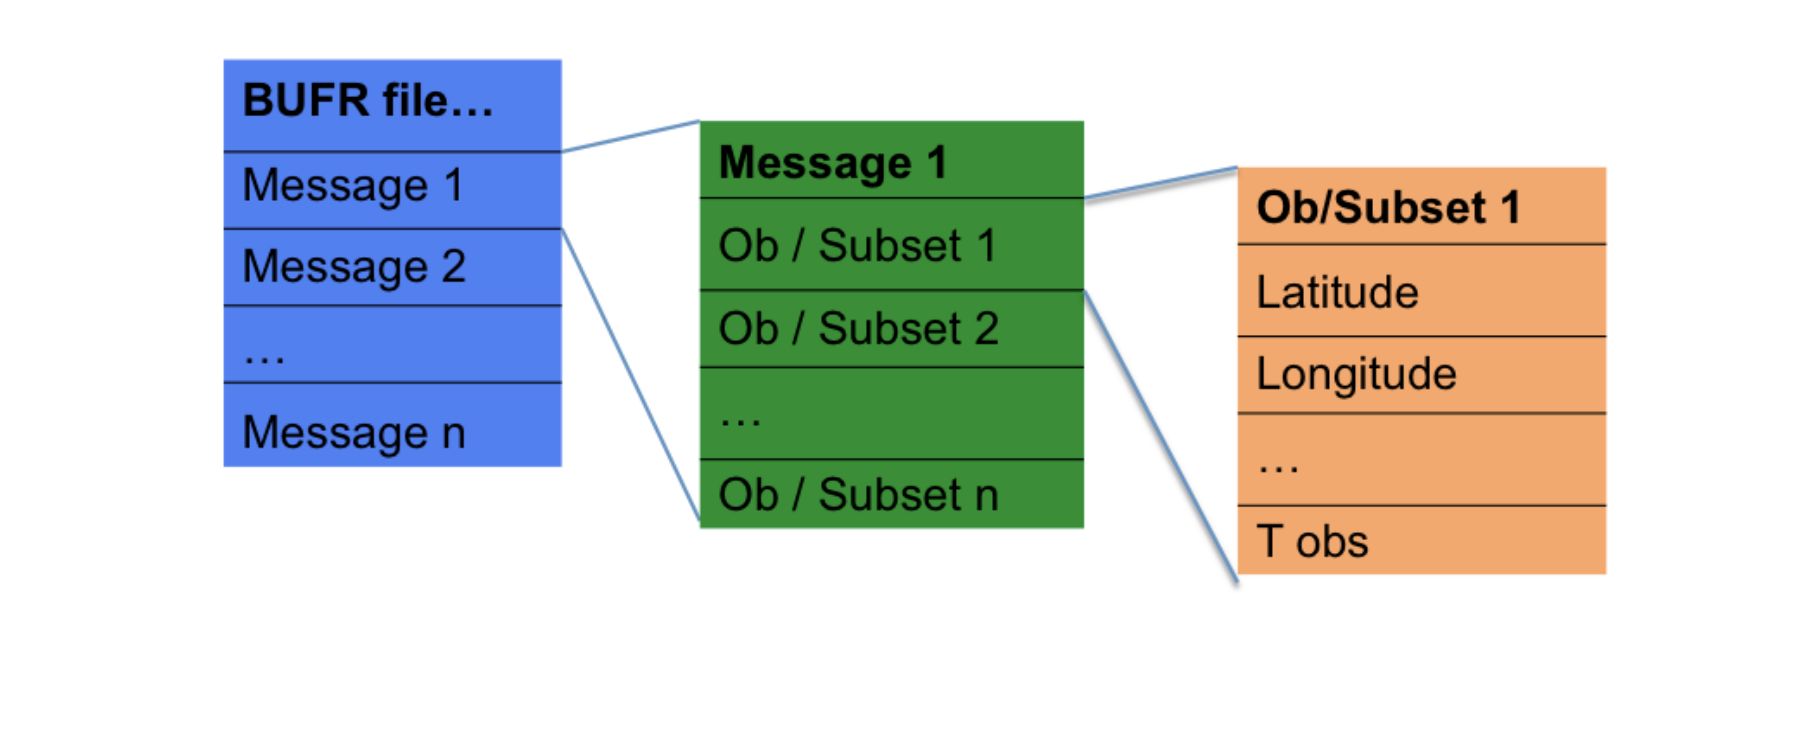

    * A file is a list of messages
    * A message is a list of observation subsets
    * A subset is a list of observation data values

* Fortran code
    * Iterates through messages and subsets
    * Then you have to tell code which data pieces to grab
        * Not sure if you can iterate through the data pieces

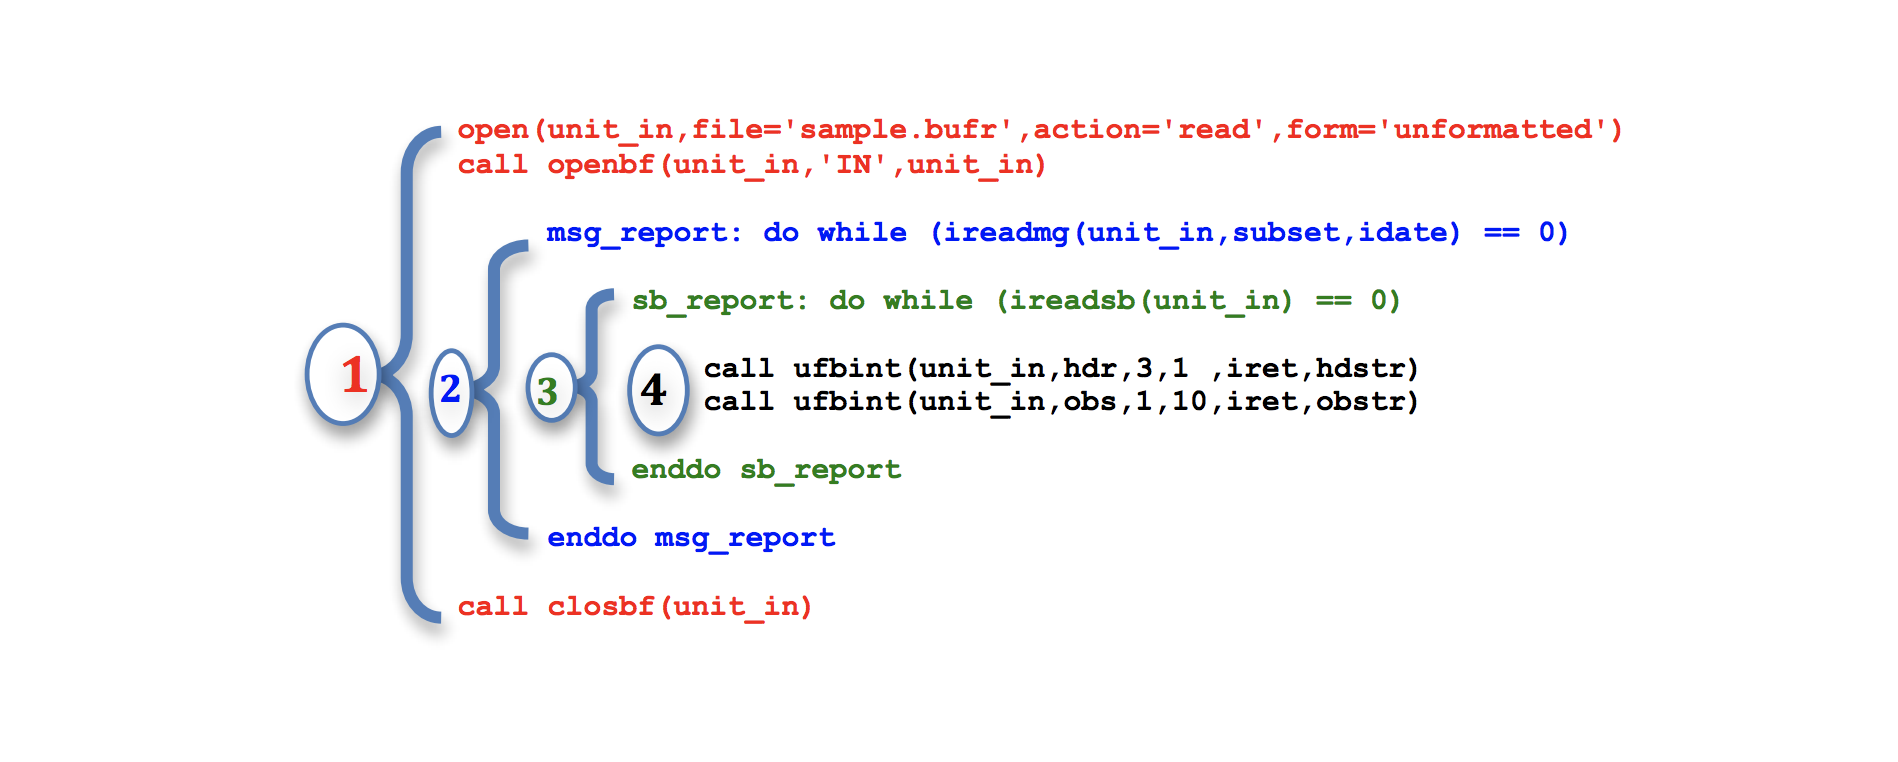

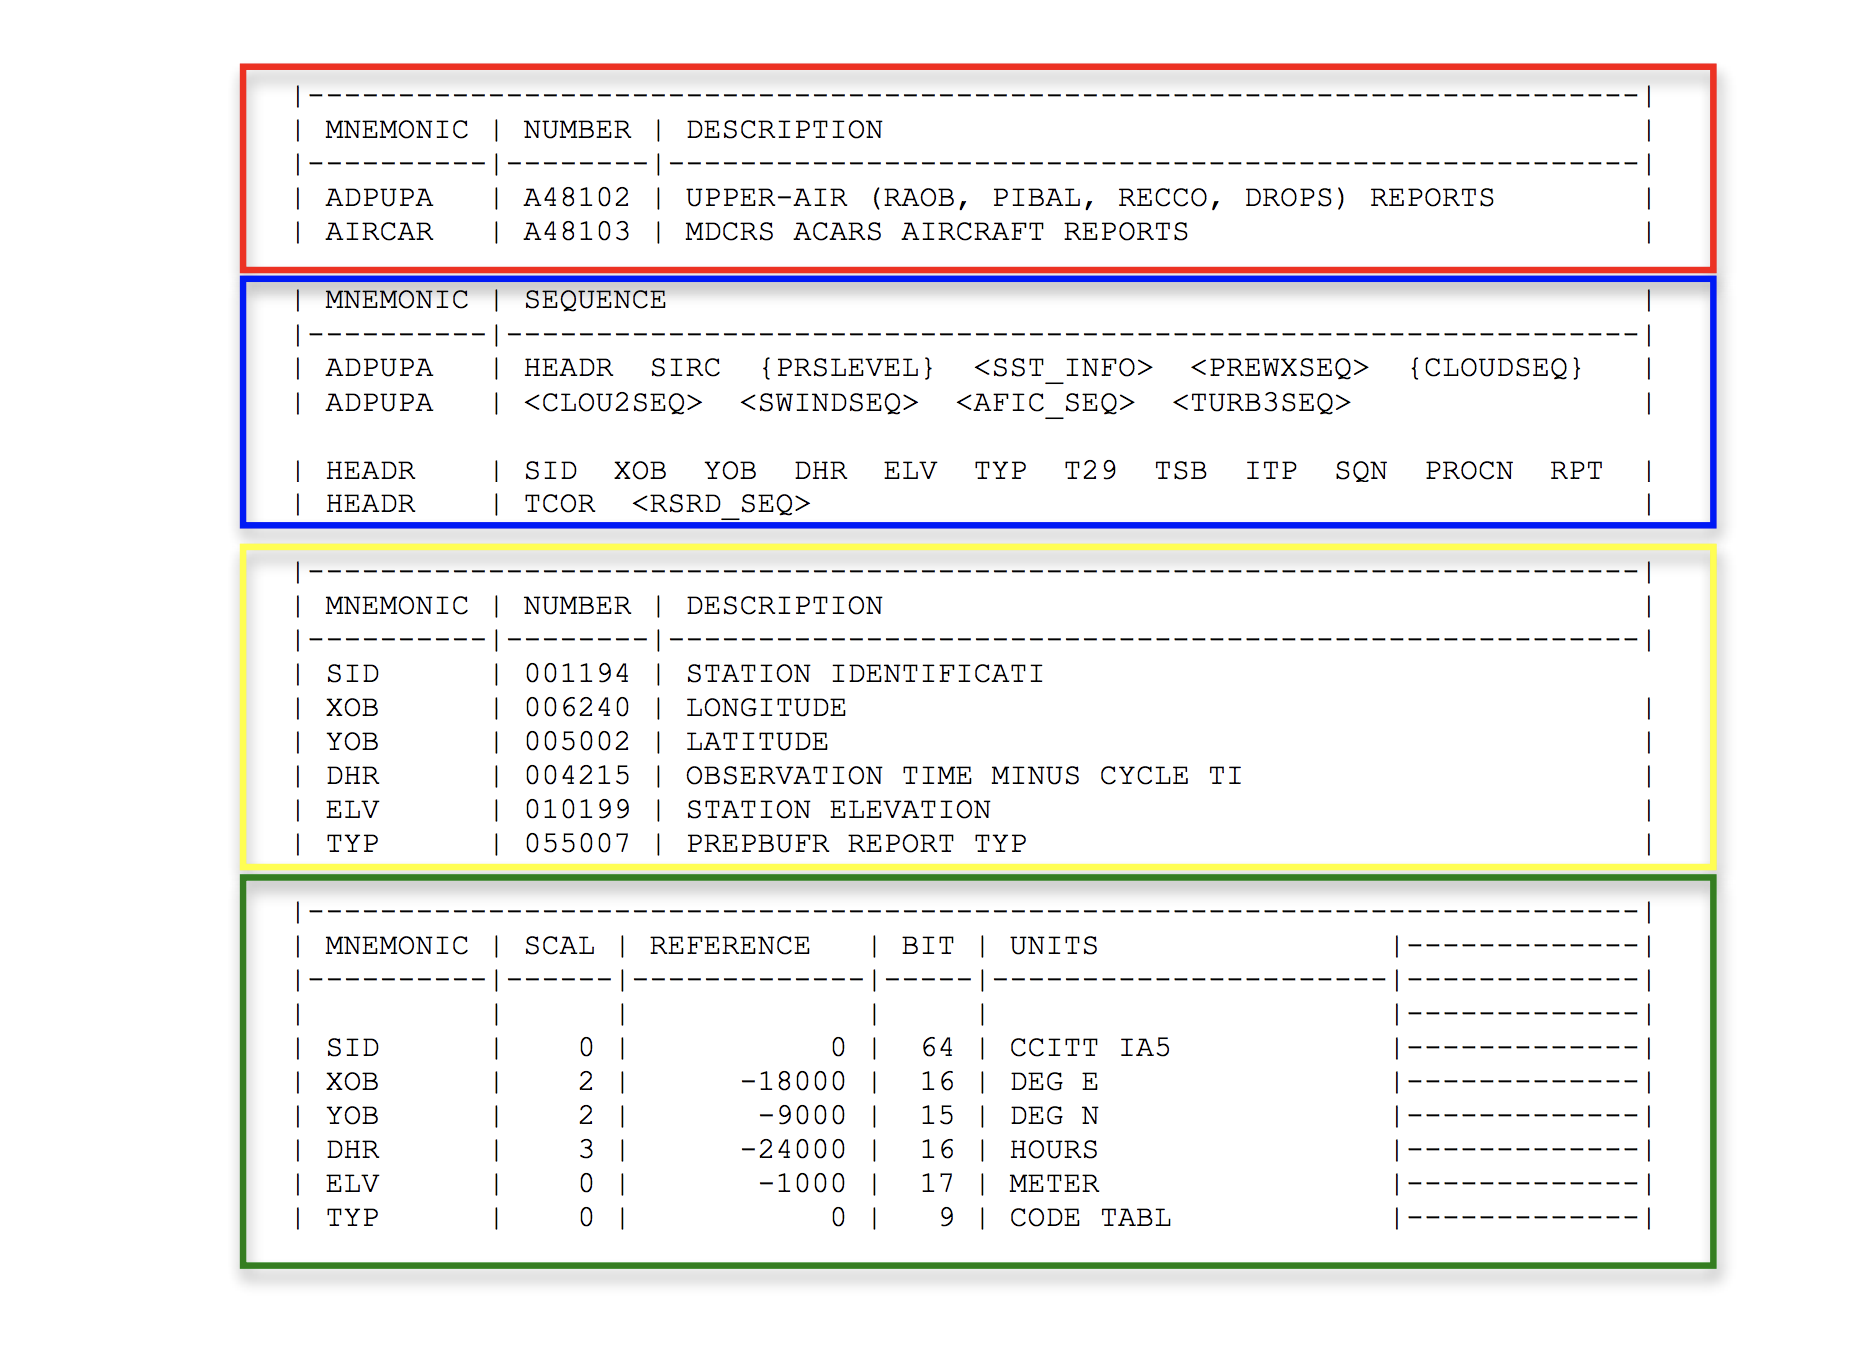

    * Colors show relationship between code and BUFR table
    * In the code for the ufbint() routine
        * hdr, obs: real arrays where obs data values go
        * hdstr, obstr: strings with space separated tokens
            * Tokens match the mnemonics in the BUFR table
            * Tokens specify which data pieces to grab

* py-ncepbufr provides a Python interface that follows the Fortran routines and method of access
    * Example taken from py-ncepbufr/utils/prepbufr2nc.py
        * Structure is similar in JEDI_conv_bufr2nc_2D.py

~~~~~~~~~
# open prepbufr file
bufr = ncepbufr.open(prepbufr_filename)

# iterate through messages
while bufr.advance() == 0:
    # bufr.advance sets:
    # bufr.msg_type
    #   bufr.msg_date
    
    # iterate through obs subsets
    while bufr.load_subset() == 0:
    
        # read data pieces
        hdr = bufr.read_subset("SID XOB ...")
        obs = bufr.read_subset("POB QOB ...")
        qc  = bufr.read_subset("PQM QQM ...")
        err = bufr.read_subset("POE QOE ...")
        
        # collect obs data into arrays
        hdrarr = ...
        obsarr = ...
        qcarr  = ...
        errarr = ...
        
    # record meta data in netCDF
    nc['msgtype'][nmsg] = bufr.msg_type
    nc['msgdate'][nmsg] = bufr.msg_date
    
    # append obs data to netCDF dataset
    nc[hdrname][nobs] = hdrarr
    ...
~~~~~~~~~

* python netCDF method is:
    * create dimension
    * create variables
        * use dimension names from first step
     * fill in variable data
        * Coordinate variable
            * Same name as dimension
            * Vector (1D array)
            * Coordinate values
        * Regular variables
            * Any shape
            * Data values


# Discussions with Ming Hu, 2/5/18 and 2/9/18

## BUFR file contents

* There is not a way to traverse BUFR file (from BUFRLIB) in an iterator fashion
    * Can do iterator for messages and subsets
    * But have to specify what you are looking for within a subset by using mnemonics
* TOB, POB, etc should be the original values
    * Only the QM flag changes
    * BUFR just saves data, does not modify data
* BUFR and prepBUFR are same format
* BUFR table is specific to a given file
* Can verify QM changes
    * Fortran programs to dump out history of data: prepbufr_decode_all_evn
        * "decode all events"

## BUFR data organization

* With a given obs, you have either single-level (scalar) or multi-level (vector)
    * Aircraft is always single-level
    * Soundings are mutli-level, but the number of levels can vary across different obs
* With multi-level obs, the number of levels can vary across different subsets
    * Even different subsets under a given message
* For a given subset, all obs will have the same number of levels
* The number of observations with single-level data is much greater than the number of observations with multi-level data
* However two variables (say T and U) may have different number of levels for one message type
    * If this is the case, T will appear in one subset while U is missing, and vice-versa in another subset
    * T and Q are typically paired in a subset
    * U and V are typically paired in a subset
    * But T, Q, U, and V are not necessarily all together in the same subsets
        * If T,Q each have 20 levels and U,V each have 30 levels then T,Q will appear in one subset while U,V appear in another
* Events represent the steps through the BUFR to prepBUFR file conversion
    * 20 is a pretty safe limit for maximum number of events since the number of steps, that we are aware of, is much less than 20
* The BUFR file allows for any number of levels and any number of events
    * Unfortunately, you cannot look at the BUFR table to ascertain the max number of levels and max number of events of obs that appear in the file.
    * There are markers in the data section of the file that denote the start and end of each obs
        * These allow the code to read in the correct amount of levels or events
* The maximum number of levels and events are both limited to 255 due to the FORTRAN implementation

## Handling data from BUFR efficiently

* There is great flexibility and consequently great variety in the number of levels that can be found in obs data
* Because of this, a linked list would be a very efficient storage mechanism
    * Each node could have the correct amount of memory to store the associate obs
    * Okay as long as we don't need to do things like sorting, searching
        * If so, a tree would be better
* SQL may be able to mimic the linked list/tree concept
    * As long as SQL can support variable record sizes
* netCDF probably cannot mimic the linked list/tree concept
    * Need to take advantage of the fact that most obs (subsets) are single level
    * Options
        * Split up into file by obs type will help a lot
        * Create groups for each message type
            * Allows for dimensions to be defined differently for each message type
            * Would work well if message type and single vs multi level are correlated
        * Store single-level and multi-level versions of each variable
            * Works regardless of correlation between single/multi levels with message type

# Notes, 2/9/18

* Handy website for BUFR description  
    http://www.nco.ncep.noaa.gov/sib/
    
    Look under "Decoders" and "BUFRLIB Software"

## BUFR table format

* Meaning of special characters

~~~~~~~~
" "n --> n regular replication of enclosed mnemonic
<> --> 1-bit (0 or 1) delayed replication of mnemonic
{} --> 8-bit (0 to 255) delayed replication of enclosed mnemonic
[] --> 16-bit (0 to 65535) delayed replication of enclosed mnemonic
~~~~~~~~

* Meaning of numeric codes

~~~~~~~~
201XXX ... 201000 --> Add XXX-128 bits to bit width of enclosed mnemonics
202XXX ... 202000 --> Change scale
203XXX ... 203000 --> Change reference value
204XXX ... 204000 --> Add associated field
205XXX ... 205000 --> Add character data
206XXX ... 206000 --> Define data width for local descriptor
207XXX ... 207000 --> Increase scale, reference value and data width
208XXX ... 208000 --> Change data width for character string
~~~~~~~~

* Example
   
~~~~~~~~
AIRCFT
...

AIRCFT HEADR <ACID_SEQ> {PRSLEVLA} <LATCORSQ> <LONCORSQ>
...

HEADR SID 207003 XOB YOB 207000 DHR ELV TYP T29 TSD ITP SQN PROCN RPT TCOR <RSRD_SEQ>
ACID_SEQ ACID
PRSLEVA RCE ROLF MSTQ IALR CAT <P___INFO> <Q___INFO> <T___INFO> <Z___INFO> <W___INFO>
        <DRFTINFO> [WI_EVENT] <ACFT_SEQ> <TURB1SEQ> <TURB2SEQ> {TURB3SEQ} {PREWXSEQ}
        {CLOUDSEQ} {AFIC_SEQ} NRLQMS
LATCORESQ 207003 YORG 207000 YCOR
LONCORESQ 207003 XORG 207000 XCOR
...

ACID    0       0    64    CCITT IA5
SID     0       0    64    CCITT IA5

XOB     2  -18000    16    DEG E
YOB     2   -9000    16    DEG N

DHR     5 -240000    23    HOURS
ELV     0   -1000    17    METER
TYP     0       0    10    CODE TABLE
T29     0       0    10    CODE TABLE
RCT     2       0    12    HOURS
ROLF    0       0     3    CODE TABLE
MSTQ    0       0    17    CODE TABLE
IALR    3  -65536     6    M/S
CAT     0       0    88    CODE TABLE
NRLQMS  0       0    15    CCITT IA5
YORG    2   -9000    16    DEG N
XORG    2  -18000    16    DEG E
YCOR    0       0     3    CODE TABLE
XCOR    0       0     3    CODE TABLE
...

~~~~~~~~

* Appears that all data is stored as integers to save space
   * Lots of obs data has small range
   * Scale, reference are used to convert between fixed point and integer
   * Lots of data can be stored in a short int (16 bits) --> great compression
   * Might be why the read routine is called ufbint() ["int" for integer]
* Units seem to imply what data type we eventually can use
   * CCITT IA5 means ASCII character string
   * CODE TABLE means integer
   * All other units mean floating point

## GSI and py-ncepbufr

* In the GSI read_prepbuf.f90 code, aircraft type codes are:
    ictype = 130, 131, 133-139, 230, 231, 322-239

* Diag files come from GSI and contain the interpolated (to obs location) model values
    * py-ncepbufr repository contains read_diag python module for reading GSI diag files
        * read_diag is a class with methods to parse diag files
        * Handles radiance and conventional obs types at this point
    * Source code is in src_diag directory
    * Sample diag files are in test directory
* py-ncepbufr methods
    * bufr.read_subset().data
        * returns 2D var [nm, nlev]
        * nm - number of mnemonics
        * nlev - number of levels
    * bufr.read_subset(..., event=True).data
        * returns 3d var [nm, nlev, nevent]
        * nm, nlev as above
        * nevent - number of events


# Notes, 2/12/18

* Reading mnemonics one by one from a subset appears to be very slow operation
    * readmg() reads data from the file into memory (message buffer)
    * readsb() reads a subset from message buffer into subset buffer/structure
    * The above operations seem to execute quickly (acceptably fast)
    * The reading of mnemonics from the subset buffer [e.g., ufbint()] takes a long time
        * May not be good to read mnemonics one per call to ufbint()
        * Not clear if this is worse than reading a long string of mnemonics per call to ufbint()
* readsb() places data into a tree structure [rdtree()]

# Notes, 2/13/18

## pb2nc

* Format in output netcdf
    * Variables
        * hdr_sid(nobs, nstring)
            * stations ids
        * hdr_vld(nobs, nstring)
            * valid time
        * obs_qty(nobs)
            * quality marks
        * hdr_arr(nobs,5)
            * 0: header index (hdr_id)
            * 1: BUFR variable index (gc, grib code, obs type)
            * 2: pressure (p)
            * 3: height or geopotential (z)
            * 4: obs value (type is determined by entry 1)
        * obs_arr(nobs,3)
            * 0: latitude
            * 1: longitude
            * 2: elevation
    * Example from Xin's prepBUFR file
        * obs_array contents

| Hdr Id | BUFR Index | Pressure | Height | Obs Value |
|:------:|:----------:|:--------:|:------:|:---------:|
|0       |11          |388.5     |7394.485|245.15     |
|0       |7           |388.5     |7394.485|7391       |
|1       |7           |388.5     |7394.485|7391       |
|1       |33          |388.5     |7394.485|29.3       |
|1       |34          |388.5     |7394.485|0          |

* 
    * These are from the first two subsets (Hdr Id == 0 and 1)
        * First: obs with T,Q but no U,V
        * Second: obs with U,V but no T,Q
        * Typical scenerio
    * BUFR index code (grib code)
        * 11 must be temperature (K)
        * 7 must be elevation (m)
        * 33 must be u wind (m/s)
        * 34 must be v wind (m/s)
    * These values correspond with jedi_bufr2nc.py output
        * first two values of POB, ZOB, TOB, UOB, VOB, ELV
 